In [1]:
#Using FastAI Library for Image Classification
#Classifying Balls (Basketball, Soccerball, Football)
#Based on fastai course-v3

In [53]:
from fastai import *
from fastai.vision import *

In [12]:
folder = 'basketball'
file = 'urls_basketball.csv'

In [15]:
folder = 'soccerball'
file = 'urls_soccerball.csv'

In [18]:
folder = 'football'
file = 'urls_football.csv'

In [19]:
path = Path('data/balls')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

In [7]:
path.ls()

[PosixPath('data/balls/urls_soccerball.csv'),
 PosixPath('data/balls/soccerball'),
 PosixPath('data/balls/football'),
 PosixPath('data/balls/urls_basketball.csv'),
 PosixPath('data/balls/basketball'),
 PosixPath('data/balls/urls_football.csv')]

In [8]:
classes = ['basketball','soccerball','football']

In [20]:
download_images(path/file, dest, max_pics=200)

In [21]:
#Removing images that can't be opened
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

In [22]:
np.random.seed(20)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [23]:
data.classes

['basketball', 'football', 'soccerball']

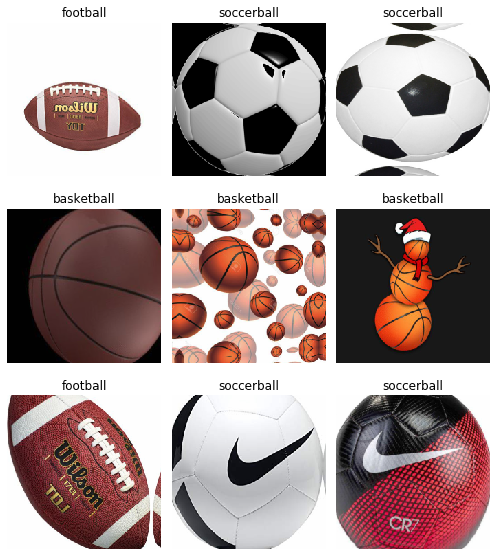

In [26]:
data.show_batch(rows=3, figsize=(7,8))

In [27]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['basketball', 'football', 'soccerball'], 3, 228, 57)

In [28]:
#Training the model
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [29]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.934600,0.665836,0.263158,00:07
1,1.192731,1.075949,0.263158,00:03
2,0.831339,1.092987,0.228070,00:03
3,0.675047,0.946784,0.210526,00:03


In [30]:
learn.save('stage-1')

In [31]:
learn.unfreeze()

In [32]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


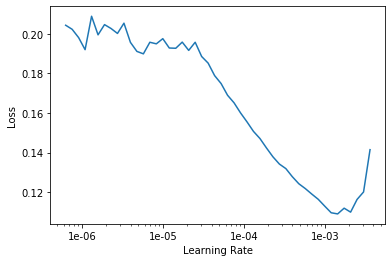

In [35]:
learn.recorder.plot()

In [36]:
learn.fit_one_cycle(2, max_lr=slice(3e-5,3e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.154067,0.995356,0.192982,00:04
1,0.143884,0.914725,0.192982,00:04


In [37]:
learn.save('stage-2')

In [38]:
#Intrepretation

learn.load('stage-2');

In [39]:
interp = ClassificationInterpretation.from_learner(learn)

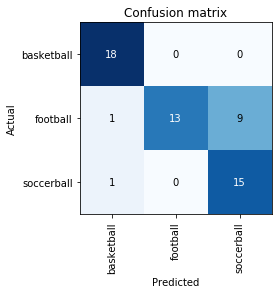

In [42]:
interp.plot_confusion_matrix()

In [44]:
learn.unfreeze()

In [45]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


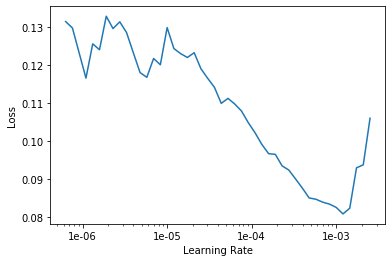

In [55]:
learn.recorder.plot()

In [60]:
#Cleaning up the data 
from fastai.widgets import *

db = (ImageList.from_folder(path)
                   .split_none()
                   .label_from_folder()
                   .transform(get_transforms(), size=224)
                   .databunch()
     )

In [61]:
learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)

learn_cln.load('stage-2');

In [62]:
#Cleaning from top losses

ds, idxs = DatasetFormatter().from_toplosses(learn_cln)

In [63]:
ImageCleaner(ds, idxs, path)

'No images to show :)'

In [65]:
#Cleaning from similar images
ds, idxs = DatasetFormatter().from_similars(learn_cln)

Getting activations...


Computing similarities...


In [66]:
ImageCleaner(ds, idxs, path, duplicates=True)

'No images to show :). 190 pairs were skipped since at least one of the images was deleted by the user.'

In [67]:
#Testing the model with the images in the dataset
#And using the model for prediction

learn.export()

In [68]:
defaults.device = torch.device('cpu')

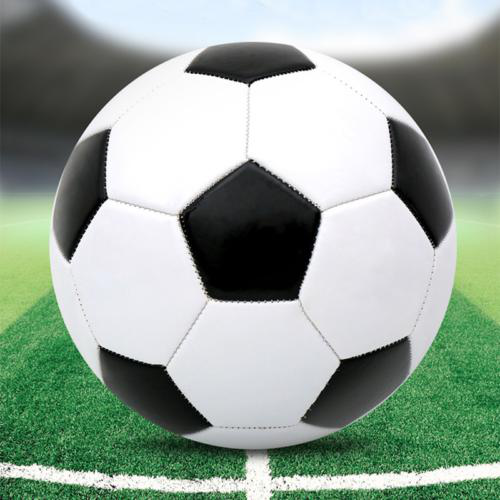

In [77]:
#getting a random image of a soccerball

img = open_image(path/'soccerball'/'00000055.jpg')
img

In [78]:
learn = load_learner(path)

In [79]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category soccerball

In [80]:
#The prediction is right
#But we also need to consider just in case the model underfits or overfits

In [81]:
#When the learning rate is too high
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [87]:
learn.fit_one_cycle(1, max_lr=0.5)

epoch,train_loss,valid_loss,error_rate,time
0,48.476200,22130.744141,0.684211,00:03


In [83]:
#This shows the error rate is also too high compared to our previous model in 'stage-2'

In [89]:
#Checking when the learning rate is too low

learn.fit_one_cycle(5, max_lr=1e-5)

epoch,train_loss,valid_loss,error_rate,time
0,27.737394,980.160706,0.684211,00:03
1,25.733166,138.369904,0.684211,00:04
2,25.779650,25.177107,0.543860,00:03
3,27.104065,22.048475,0.508772,00:03
4,27.243368,24.070656,0.473684,00:03


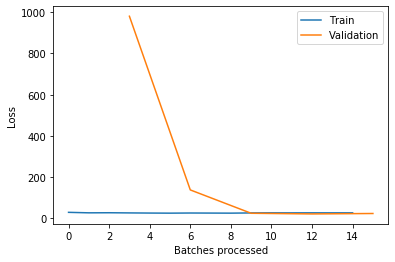

In [90]:
#The error-rate is high when the learning rate is too low

learn.recorder.plot_losses()

In [91]:
#This shows Overfitting when the learning rate is too low

#Thus, it seems the model we had in 'stage-2' is the best-fit so far

#Exploring the overfitting and underfitting again with epochs.

In [92]:
#With too few epochs

learn = cnn_learner(data, models.resnet34, metrics=error_rate, pretrained=False)

In [93]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,1.859529,16.456089,0.719298,00:04


In [97]:
#with too many epochs

data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.9, bs=25, 
        ds_tfms=get_transforms(do_flip=False, max_rotate=0, max_zoom=1, max_lighting=0, max_warp=0
                              ),size=224, num_workers=4).normalize(imagenet_stats)

In [98]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate, ps=0, wd=0)
learn.unfreeze()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/ubuntu/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 79.8MB/s]


In [99]:
learn.fit_one_cycle(40, slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,1.384678,2.267328,0.699219,00:11
1,1.259581,2.052639,0.703125,00:03
2,1.160105,1.881454,0.710938,00:03
3,1.101874,1.712966,0.695312,00:03
4,1.016642,1.577311,0.667969,00:03
5,0.922945,1.446347,0.644531,00:03
6,0.827846,1.327932,0.582031,00:03
7,0.741535,1.217174,0.519531,00:03
8,0.664601,1.128336,0.460938,00:03
9,0.599774,1.061619,0.425781,00:03


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


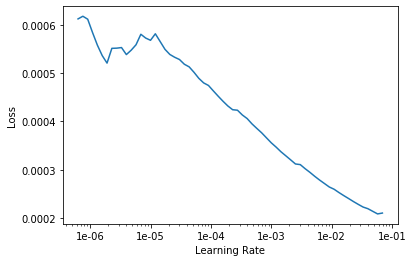

In [101]:
#Visualizing Learning Rate Vs Loss
learn.lr_find()
learn.recorder.plot()

In [127]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)
learn.fit_one_cycle(4, max_lr=slice(3e-5,3e-1))

epoch,train_loss,valid_loss,error_rate,time
0,1.916574,1.885113,0.191406,00:02
1,0.950971,11.851436,0.199219,00:02
2,0.627610,8.907982,0.218750,00:02
3,0.469233,6.091496,0.242188,00:02


In [ ]:
#Thus, after the data has been cleaned the model with 4 epochs and relatively low learning rate gives us the lowest error-rate.